# Complete analysis for Experiment 1

In [1]:
rm(list=ls())

In [26]:
library(tidyverse)
library(lme4)
library(lmerTest)
library(car)
library(binom)

## Loading data

In [3]:
data.folder <- 'Experiment 1.'
file.list <- list.files(path= data.folder, pattern= 'csv$')
reports <- data.frame()
for(current.filename in file.list){
    current.observer <- read.csv2(file.path(paste(data.folder, current.filename, sep='/')))
    
    # extracting disambiguation method from 
    current.observer$disambiguation.method <- str_extract(current.filename, 'perspective|stereo')
    
    # discarding mixed phases
    current.observer <- current.observer[-which(current.observer$Percept=='unclear'), ]
    
    # splitting Unambiguous and Percept columns into one-column-per-object
    current.observer$unambiguous.L <- FALSE
    current.observer$unambiguous.L[current.observer$Unambiguious=='left'] <- TRUE
    current.observer$unambiguous.R <- FALSE
    current.observer$unambiguous.R[current.observer$Unambiguious=='right'] <- TRUE
    current.observer$ambiguity <- 'one'
    current.observer$ambiguity[current.observer$Unambiguious=='neither'] <- 'both'   
    
    # rotation of the left object
    current.observer$rotation.L <- 0 # unclear
    current.observer$rotation.L[current.observer$Percept %in% c('left', 'down')] <- -1
    current.observer$rotation.L[current.observer$Percept %in% c('right', 'up')] <- 1

    # rotation of the right object
    current.observer$rotation.R <- 0 # unclear
    current.observer$rotation.R[current.observer$Percept %in% c('left', 'up')] <- -1                              
    current.observer$rotation.R[current.observer$Percept %in% c('right', 'down')] <- 1                              

    # counter.rotation
    current.observer$counter.rotation <- NA
    current.observer$counter.rotation[current.observer$Percept %in% c('left', 'right')] <- FALSE
    current.observer$counter.rotation[current.observer$Percept %in% c('up', 'down')] <- TRUE
    
    # prettifying shape labels
    current.observer$Shape <- gsub('-0500', '', current.observer$Shape)
    
    # merging
    reports <- rbind(reports, current.observer)
}

# Computing duration of individual reports
reports <- reports %>%
    dplyr::group_by(Observer, Block) %>%
    dplyr::mutate(Duration= c(diff(Time), NA)) %>%
    ungroup()

# Converting Gap to a factor
reports <- reports %>%
    mutate(Gap= dplyr::recode(Gap, `-0.15`= 'overlap', `0`='touching', `0.15`= 'gap')) %>%
    mutate(Gap= factor(Gap, levels= c('overlap', 'touching', 'gap')))


# bias direction label
reports$Direction.label <- ifelse(reports$Direction==-1, 'left', 'right')

# converting strings to factors
reports$ambiguity <- as.factor(reports$ambiguity)

## Computing demographics info, reported in the _Methods_ section

In [4]:
participants <- data.frame(Observer= unique(reports$Observer))
demographics <- participants %>%
    mutate(Observer= str_replace(Observer, '(R|r)$', ''), # removing trailing R, which is present for some participants
           gender= ifelse(str_detect(Observer, '(W|w)$'), 'female', 'male'),
           birth.year= as.numeric(str_extract(Observer, '\\d{2,4}')),
           birth.year= ifelse(birth.year<100, birth.year+1900, birth.year),
           age= 2017-birth.year) %>%

    group_by(gender) %>%
    summarise(count= n(), 
              min.age= min(age),
              max.age= max(age))

demographics

gender,count,min.age,max.age
female,12,19,36
male,5,21,29


## Effectiveness of disambiguation cues
Figure 2A in the manuscript

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-168.0538,-160.1789,87.02692,-174.0538,NA,NA,NA
lm.gap,5,-166.3806,-153.2557,88.19030,-176.3806,2.326767,2,0.31242732
lm.shape,6,-165.4221,-149.6722,88.71103,-177.4221,1.041448,1,0.30748490
lm.method,7,-166.6950,-148.3202,90.34750,-180.6950,3.272951,1,0.07043082


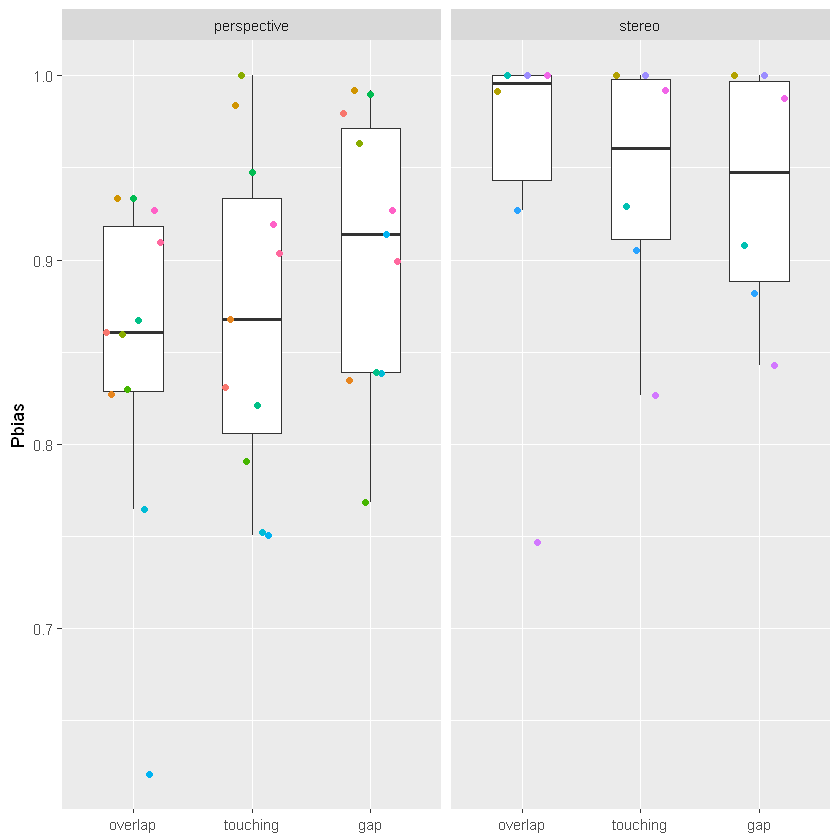

In [5]:
# disambiguation effect for each observer and gap x shape condition
disambiguation <- reports %>%
    dplyr::filter(Unambiguious != 'neither') %>% # considering only blocks with disambiguation cues
    dplyr::mutate(biased.object.percept= ifelse(Unambiguious=='left', rotation.L, rotation.R)) %>% # selecting disambiguated object
    dplyr::filter(is.finite(counter.rotation)) %>%
    dplyr::group_by(Observer, Block, Gap, Shape, disambiguation.method) %>% # computing fraction of time observers reported that congruent percept in each block
    dplyr::summarize(biased.fraction= sum(Duration[Direction == biased.object.percept])/sum(Duration)) %>%
    dplyr::group_by(Observer, Gap, Shape, disambiguation.method) %>%
    dplyr::summarize(biased.fraction= mean(biased.fraction))

# looking at the effect of condition on disambiguation cues effectiveness
lm.null <- lme4::lmer(biased.fraction ~ 1 + (1|Observer), data= disambiguation, REML= FALSE)
lm.gap <- update(lm.null, .~. + Gap)
lm.shape <- update(lm.gap, .~. + Shape)
lm.method <- update(lm.shape, .~. + disambiguation.method)
anova(lm.null, lm.shape, lm.gap, lm.method)

disambiguation <- disambiguation %>%
    dplyr::group_by(Observer, Gap, disambiguation.method) %>%
    dplyr::summarize(biased.fraction= mean(biased.fraction))

# plotting disambiguation effect per condition (gap x shape)
disambiguation.plot <- ggplot(data= disambiguation, 
                              aes(x= interaction(Gap), y= biased.fraction))+
    geom_boxplot(outlier.shape =  NA, width= 0.5 )+
    geom_point(aes(color= Observer), position= position_dodge(width= 0.5))+
    ylab('Pbias')+
    xlab('Layout')+
    facet_grid(. ~ disambiguation.method)+
    theme(legend.position="none", axis.title.x=element_blank())
print(disambiguation.plot)

## Computing fraction of time observers perceived _counter-rotation_ 

In [6]:
# computing fraction of time observers reported counter-rotation throughout each block
counter.rotation <- reports %>%
    dplyr::filter(is.finite(counter.rotation)) %>%
    dplyr::group_by(Observer, Block, Shape, Gap, ambiguity, disambiguation.method) %>%
    dplyr::summarize(fraction= sum(Duration[counter.rotation])/sum(Duration)) %>%
    dplyr::group_by(Observer, Shape, Gap, ambiguity, disambiguation.method) %>%
    dplyr::summarize(fraction= mean(fraction))

# converting everything to factors for analysis
counter.rotation <- data.frame(counter.rotation)
counter.rotation$Gap <- as.factor(counter.rotation$Gap)
counter.rotation$ambiguity <- as.factor(counter.rotation$ambiguity)
counter.rotation$Shape <- as.factor(counter.rotation$Shape)
counter.rotation$disambiguation.method <- as.factor(counter.rotation$disambiguation.method)

# same by using multilevel apporach via linear-mixed models
lm.null <- lme4::lmer(fraction ~ 1 + (1|Observer), data= counter.rotation, REML= FALSE)
lm.gap <- update(lm.null, .~.+Gap)
lm.shape <- update(lm.gap, .~.+Shape)
lm.ambiguity <- update(lm.shape, .~.+ambiguity)
lm.disambiguation <- update(lm.ambiguity, .~. + disambiguation.method)
lm.shape.layout <- update(lm.disambiguation, .~. + Shape*Gap)
anova(lm.null, lm.shape, lm.gap, lm.ambiguity, lm.disambiguation, lm.shape.layout)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-18.05446,-8.100098,12.02723,-24.05446,NA,NA,NA
lm.gap,5,-40.04029,-23.449690,25.02014,-50.04029,25.9858315,2,2.276399e-06
lm.shape,6,-45.11582,-25.207103,28.55791,-57.11582,7.0755334,1,7.814356e-03
lm.ambiguity,7,-66.41777,-43.190931,40.20889,-80.41777,23.3019479,1,1.384597e-06
lm.disambiguation,8,-64.91518,-38.370223,40.45759,-80.91518,0.4974115,1,4.806397e-01
lm.shape.layout,10,-65.25840,-32.077199,42.62920,-85.25840,4.3432160,2,1.139942e-01


### Plotting all conditions  together for a birds-eye view
Figure 2B in the manuscript

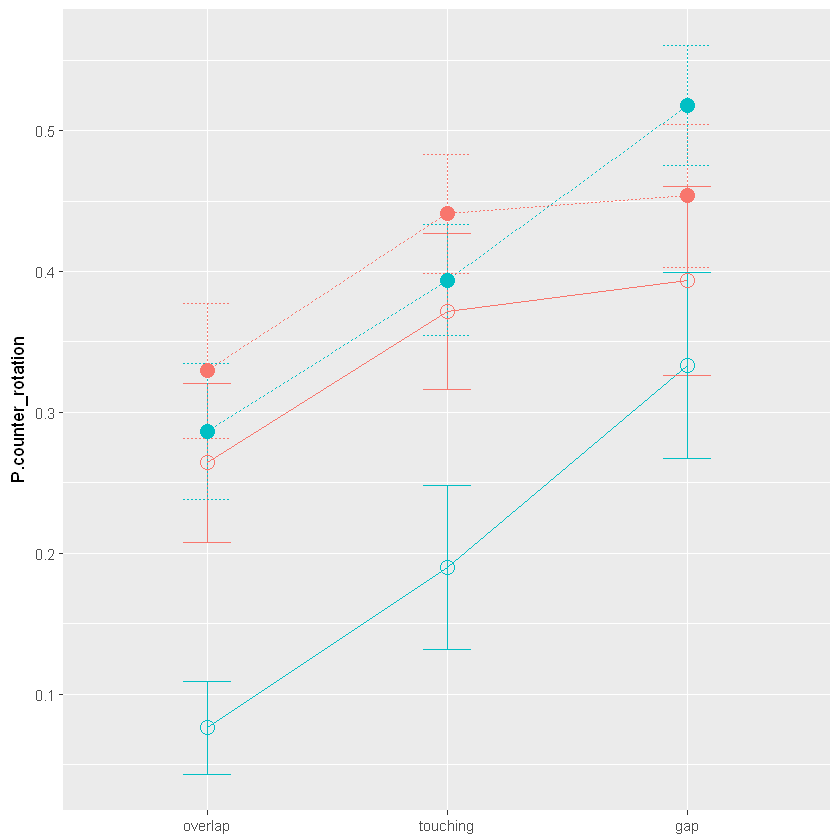

In [7]:
overall.averages <- counter.rotation %>%
    dplyr::group_by(Shape, Gap, ambiguity) %>%
    dplyr::summarise(P.counter_rotation= mean(fraction), 
                     P.serr= sd(fraction)/sqrt(n()-1), 
                     P.25=  quantile(fraction)[2],
                     P.75= quantile(fraction)[4])

overall.plot <- ggplot(data= overall.averages, aes(x= Gap, y= P.counter_rotation,
                                                  ymin= P.counter_rotation-P.serr, ymax= P.counter_rotation + P.serr,
                                                  group= interaction(Shape, ambiguity), color= Shape, shape= ambiguity,
                                                  linetype = ambiguity)) + 
    geom_line() + 
    geom_errorbar(width=0.2) + 
    geom_point(size= 4)+
    theme(legend.position="none", axis.title.x=element_blank())+
    xlab('Pcounter-rotation')+
    scale_shape_manual(values = c(1, 16))


print(overall.plot)
ggsave('Figures/Exp1 - overall.pdf', overall.plot, width= 6, height= 6.5, units = 'cm', useDingbats = FALSE)

### Plotting main effect of the gap
Figure 2C

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: fraction ~ Gap + (1 | Observer)
   Data: counter.rotation

REML criterion at convergence: -34.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.36887 -0.73081 -0.03676  0.70952  2.88215 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.005957 0.07718 
 Residual             0.042850 0.20700 
Number of obs: 204, groups:  Observer, 17

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.23913    0.03131  46.70000   7.636 9.29e-10 ***
Gaptouching   0.10995    0.03550 185.00000   3.097  0.00226 ** 
Gapgap        0.18537    0.03550 185.00000   5.222 4.74e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) Gptchn
Gaptouching -0.567       
Gapgap      -0.567  0.500

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.2391291,0.03131409,46.70485,7.636471,9.285250e-10,0.7451704
0.1099462,0.03550060,185.00009,3.097023,2.259193e-03,0.2220150
0.1853681,0.03550060,185.00009,5.221548,4.743265e-07,0.3583937


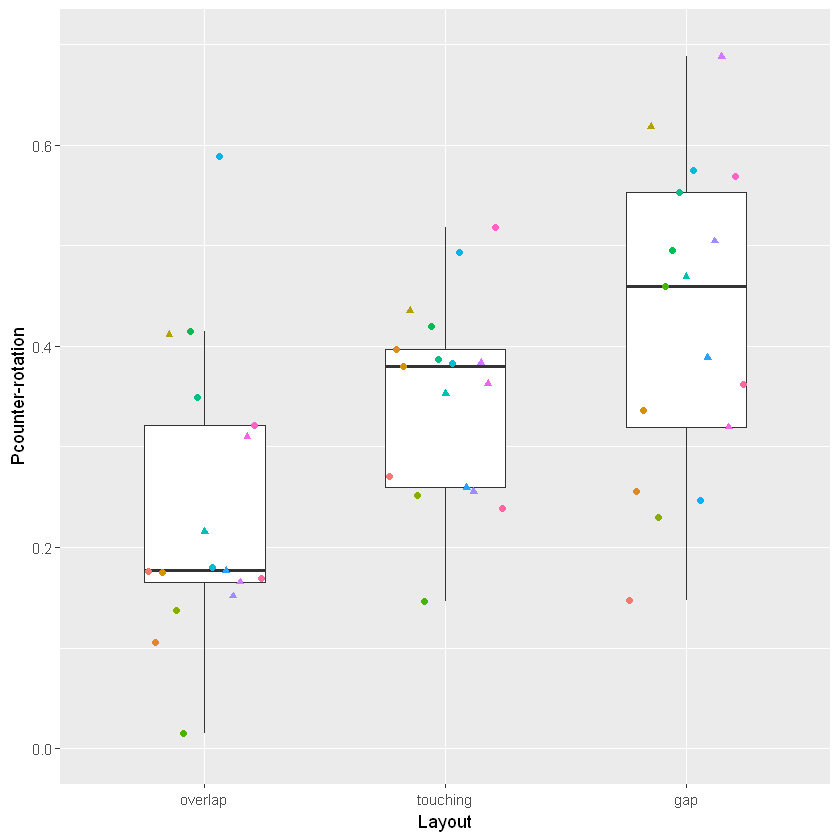

In [8]:
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}

gap.df <- counter.rotation %>%
    dplyr::group_by(Observer, Gap, disambiguation.method) %>%
    dplyr::summarize(fraction= mean(fraction))

# using gap as the only factor in LMER
gap.as.only.factor <- lmerTest::lmer(fraction ~ Gap + (1|Observer), data= counter.rotation)
summary(gap.as.only.factor)
coefficients.only <- data.frame(summary(gap.as.only.factor)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

gap.plot <- ggplot(data= gap.df, aes(x= Gap, y= fraction))+
    geom_boxplot(outlier.shape =  NA, width= 0.5)+
    geom_point(aes(color= Observer, shape= disambiguation.method), , position= position_dodge(width= 0.5))+
    ylim(0, 0.7)+
    ylab('Pcounter-rotation')+
    xlab('Layout')+
    theme(legend.position="none")
print(gap.plot)
ggsave('Figures/Exp1 - main effect of gap.pdf', gap.plot, width= 6, height= 6.5, units = 'cm',  useDingbats = FALSE)

### Plotting main effect of the ambiguity
Figure 2D

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: fraction ~ ambiguity + (1 | Observer)
   Data: counter.rotation

REML criterion at convergence: -32.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8222 -0.8023 -0.0684  0.6523  3.5657 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.005848 0.07647 
 Residual             0.044165 0.21016 
Number of obs: 204, groups:  Observer, 17

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    0.27136    0.02787  30.36000   9.735 7.53e-11 ***
ambiguityone   0.13242    0.02943 186.00000   4.500 1.20e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
ambiguityon -0.528

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.2713583,0.02787422,30.35848,9.735101,7.531087e-11,0.8702791
0.1324177,0.02942770,186.00009,4.499766,1.196642e-05,0.3133250


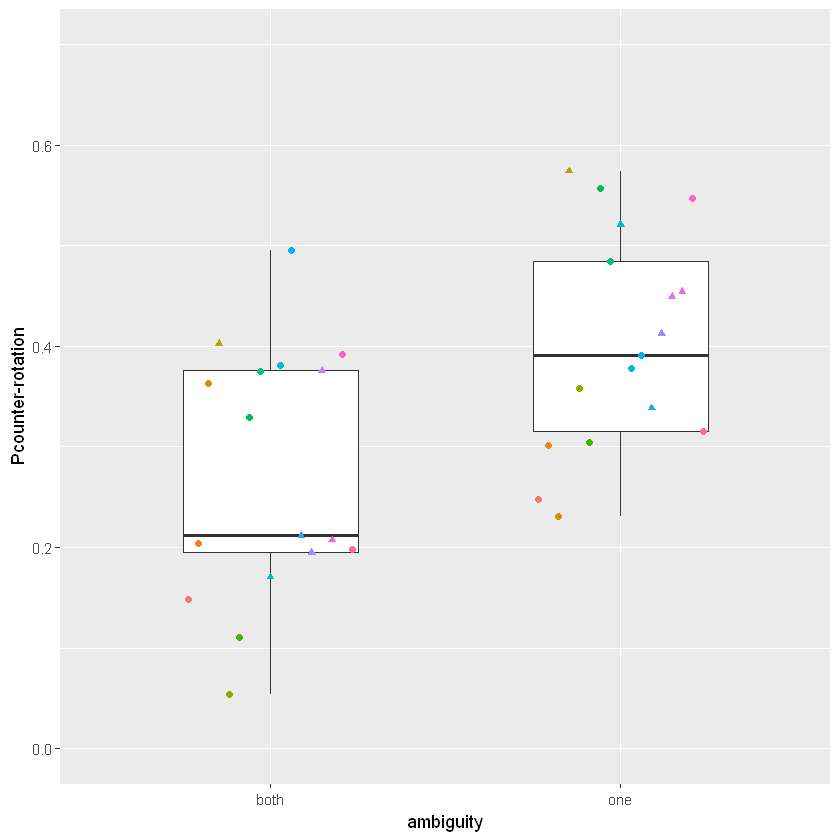

In [9]:
amb.df <- counter.rotation %>%
    dplyr::group_by(Observer, ambiguity, disambiguation.method) %>%
    dplyr::summarize(fraction= mean(fraction))

# using ambiguity as the only factor in LMER
ambiguity.as.only.factor <- lmerTest::lmer(fraction ~ ambiguity + (1|Observer), data= counter.rotation)
summary(ambiguity.as.only.factor)
coefficients.only <- data.frame(summary(ambiguity.as.only.factor)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

amb.plot <- ggplot(data= amb.df, aes(x= ambiguity, y= fraction))+
    geom_boxplot(outlier.shape = NA, width= 0.5)+
    geom_point(aes(color= Observer, shape= disambiguation.method), position = position_dodge(width= 0.5))+
    ylim(0, 0.7)+
    ylab('Pcounter-rotation')+
    theme(legend.position="none")
print(amb.plot)
ggsave('Figures/Exp1 - main effect of ambiguity.pdf', amb.plot, width= 4.5, height= 6.5, units = 'cm',  useDingbats = FALSE)

### Plotting main effect of the shape
Figure 2E

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: fraction ~ Shape + (1 | Observer)
   Data: counter.rotation

REML criterion at convergence: -19.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0085 -0.8024  0.0078  0.6387  3.3082 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.005579 0.07469 
 Residual             0.047391 0.21769 
Number of obs: 204, groups:  Observer, 17

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.37555    0.02816  31.55000  13.338 1.64e-14 ***
Shapesphere  -0.07597    0.03048 186.00000  -2.492   0.0136 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
Shapesphere -0.541

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.37555200,0.02815640,31.54606,13.338070,1.643130e-14,0.9216216
-0.07596955,0.03048331,186.00008,-2.492169,1.357104e-02,0.1797581


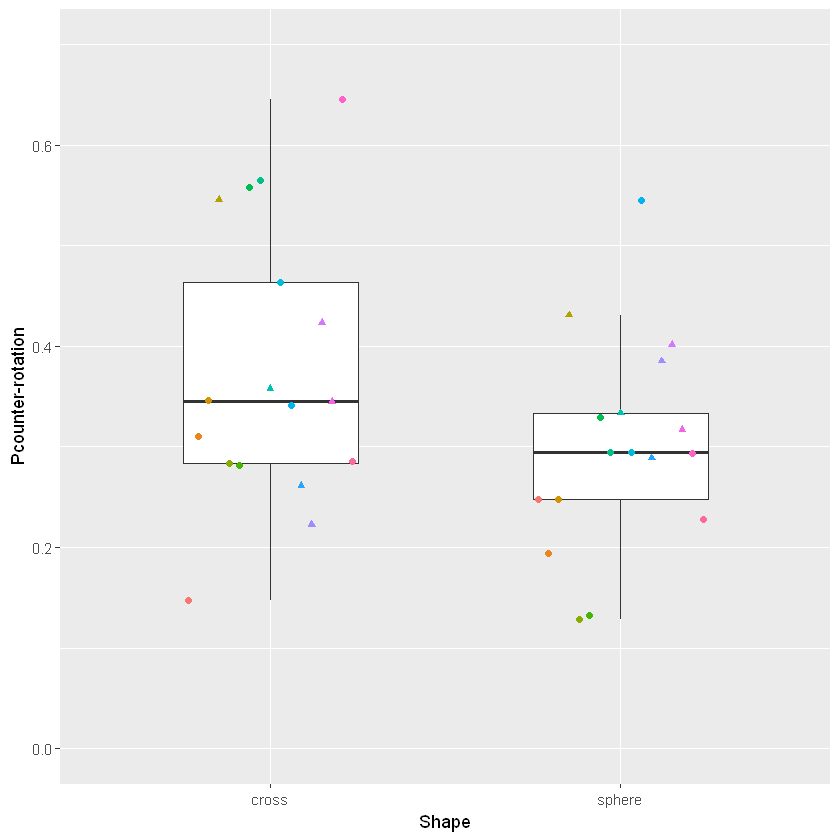

In [10]:
shape.df <- counter.rotation %>%
    dplyr::group_by(Observer, Shape, disambiguation.method) %>%
    dplyr::summarize(fraction= mean(fraction))

# using shape as the only factor in LMER
shape.as.only.factor <- lmerTest::lmer(fraction ~ Shape + (1|Observer), data= counter.rotation)
summary(shape.as.only.factor)
coefficients.only <- data.frame(summary(shape.as.only.factor)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))


shape.plot <- ggplot(data= shape.df, aes(x= Shape, y= fraction))+
    geom_boxplot(outlier.shape = NA, width= 0.5)+
    geom_point(aes(color= Observer, shape= disambiguation.method), position = position_dodge(width= 0.5))+
    ylim(0, 0.7)+
    ylab('Pcounter-rotation')+
    theme(legend.position="none")
print(shape.plot)
ggsave('Figures/Exp1 - main effect of shape.pdf', shape.plot, width= 4.5, height= 6.5, units = 'cm',  useDingbats = FALSE)

## Evaluating perceptual trapping and simultaneity of perceptual reversals in two objects 
This is __Figure 3__ in the manuscript.


Marking out perceptual switches in individual objects

In [11]:
mark.perceptual.switch.but.not.onset.or.offset <- function(Pprev, Pcurrent){
    # Computes whether the object's perceptual state switch, but ignores onset and offset events
    Pprev[Pprev==0] <- NA
    Pcurrent[Pcurrent==0] <- NA
    return(Pprev!=Pcurrent)
}

reports <- reports %>% 
    # marking out switches for the left and for the right object separately
    group_by(Observer, Block) %>%
    mutate(iTrial= 1:n(), 
           left.switch= mark.perceptual.switch.but.not.onset.or.offset(lag(rotation.L, order_by = iTrial), rotation.L),
           right.switch= mark.perceptual.switch.but.not.onset.or.offset(lag(rotation.R, order_by = iTrial), rotation.R),
           both.switch= left.switch & right.switch)

Computing dominance phase duration for each object separately

In [12]:
compute.dominance.phase.duration <- function(time, percept){
    # first NA, because we are not interested in a change from "no report" to reported perception
    changes= which(c(NA, abs(diff(percept))>0))
    duration <- rep(NA, length(time))
    for (iSwitch in 1:(length(changes)-1)){
        duration[changes[iSwitch]] <- time[changes[iSwitch+1]]-time[changes[iSwitch]];
    }
    
    return (duration)
}

reports <- reports %>%
    group_by(Observer, Block) %>%
    mutate(D.left= compute.dominance.phase.duration(Time, rotation.L), 
           D.right= compute.dominance.phase.duration(Time, rotation.R))

Selecting blocks that have at least 5 switches for each object

In [13]:
minimal.switch.count <- 5
eligible.blocks <- reports %>%
    # counting number of switches per object
    group_by(Observer, Block) %>%
    filter(is.finite(counter.rotation)) %>%
    summarise(left.switch.count= sum(left.switch, na.rm= TRUE), 
              right.switch.count= sum(right.switch, na.rm= TRUE), 
              mean.switch.count= mean(c(left.switch.count, right.switch.count)),
              sim.switch.prop= sum(left.switch==TRUE & right.switch==TRUE, na.rm= TRUE)/sum(is.finite(left.switch)),
              counter.rotation.prop= sum(Duration[counter.rotation])/sum(Duration, na.rm = TRUE),
              disbalance= abs(counter.rotation.prop-0.5),
              balanced= (counter.rotation.prop>0.25) & (counter.rotation.prop<0.75)) %>%

    # retaining only the blocks with at least minimal.switch.count switches 
    filter(left.switch.count>= minimal.switch.count & 
           right.switch.count>= minimal.switch.count)

cat(sprintf('Number of eligible blocks: %d\n', nrow(eligible.blocks)))
cat(sprintf('Number of eligible participants: %d\n', length(unique(eligible.blocks$Observer))))

Number of eligible blocks: 123
Number of eligible participants: 15


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: sim.switch.prop ~ disbalance + (1 | Observer)
   Data: eligible.blocks

REML criterion at convergence: -67.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3809 -0.5877  0.0618  0.6575  3.3082 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.004091 0.06396 
 Residual             0.029389 0.17143 
Number of obs: 123, groups:  Observer, 15

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   0.1883     0.0401  39.6000   4.696 3.16e-05 ***
disbalance    1.2808     0.1007 118.5300  12.721  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
           (Intr)
disbalance -0.801

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.1882947,0.04009678,39.60212,4.696005,3.160618e-05,0.5980616
1.2807855,0.10068228,118.53350,12.721062,0.000000e+00,0.7597421


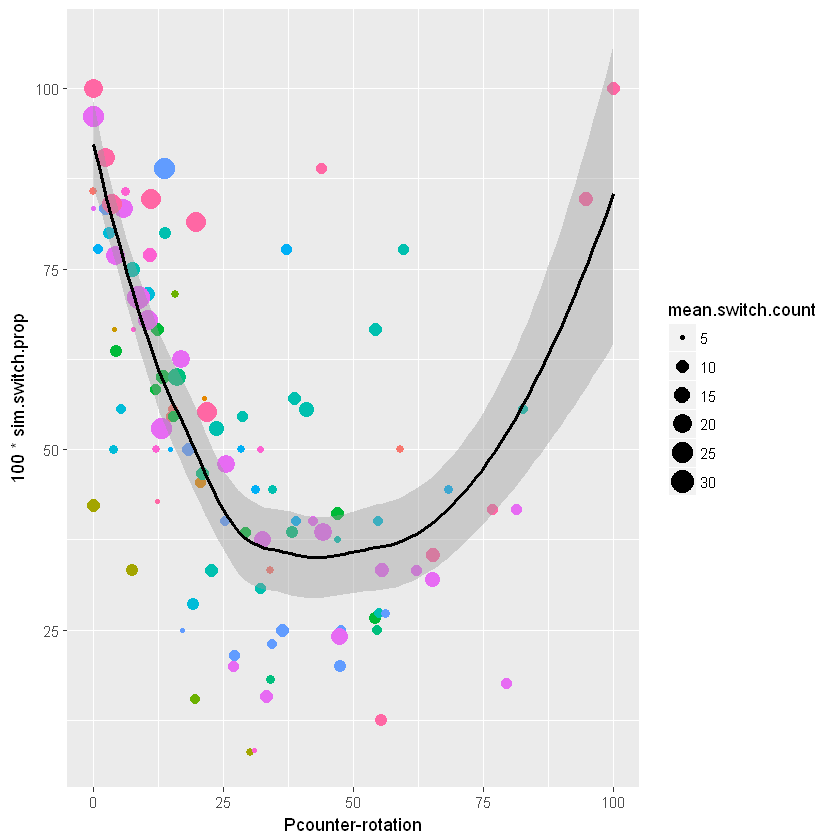

In [14]:
sim.switch.model <- lmerTest::lmer(sim.switch.prop ~ disbalance + (1|Observer), data= eligible.blocks)
summary(sim.switch.model)
coefficients.only <- data.frame(summary(sim.switch.model)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

# summary(lmerTest::lmer(sim.switch.prop ~ disbalance + (1|Observer), data= eligible.blocks))

coupling.vs.sim.switches.plot <- ggplot(data= eligible.blocks, aes(x= 100*counter.rotation.prop, y= 100*sim.switch.prop)) +
#     geom_point(aes(fill= Observer, size= mean.switch.count, color= balanced), pch=21)+
    geom_point(aes(color= Observer, size= mean.switch.count))+
    geom_smooth(color= 'black', method='loess')+
    scale_colour_discrete(guide = FALSE) +
#     scale_colour_manual(values=c('#FFFFFF00', '#000000FF'))+
    xlab('Pcounter-rotation')
print(coupling.vs.sim.switches.plot)
ggsave('Figures/Exp1 - independent switching versus coupling.pdf', coupling.vs.sim.switches.plot, width= 13, height= 7.5, units = 'cm',  useDingbats = FALSE)

Looking whether perceptual trapping makes ambiguous objects more or less stable by counting a mean number of perceptual switches

In [180]:
ambiguous.blocks <- reports %>%
    filter(Unambiguious == 'neither') %>%
    filter(is.finite(counter.rotation)) %>%
    # counting number of switches per object
    group_by(Observer, Block) %>%
    summarise(left.switch.count= ifelse(unambiguous.L[1], NA, sum(left.switch, na.rm= TRUE)), # ignoring disambiguated object
              right.switch.count= ifelse(unambiguous.R[1], NA, sum(right.switch, na.rm= TRUE)), # ignoring disambiguated object
              mean.switch.count= mean(c(left.switch.count, right.switch.count)),
              counter.rotation.prop= sum(Duration[counter.rotation])/sum(Duration, na.rm = TRUE),
              disbalance= abs(counter.rotation.prop-0.5),
              balanced= (counter.rotation.prop>0.25) & (counter.rotation.prop<0.75)) %>%
    filter(is.finite(mean.switch.count))

N.switch.model <- lmerTest::lmer(mean.switch.count ~ disbalance + (1|Observer), data= all.blocks)
summary(N.switch.model)
coefficients.only <- data.frame(summary(N.switch.model)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: mean.switch.count ~ disbalance + (1 | Observer)
   Data: all.blocks

REML criterion at convergence: 1158.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0060 -0.5911 -0.1744  0.3853  4.4141 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 13.10    3.619   
 Residual             17.35    4.165   
Number of obs: 198, groups:  Observer, 17

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)   
(Intercept)    3.990      1.138  33.900   3.506  0.00130 **
disbalance     5.354      1.991 188.520   2.689  0.00781 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
           (Intr)
disbalance -0.579

Estimate,Std.Error,df,t.value,p.value,R.sqr
3.989935,1.137919,33.90031,3.506344,0.001301353,0.5158913
5.354335,1.991144,188.51674,2.689075,0.007807304,0.1922005


#### Effect of the gap on perceptual stability
Figure 3D in the manuscript

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: mean.switch.count ~ Gap + (1 | Observer)
   Data: ambiguous.gap

REML criterion at convergence: 1159.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1062 -0.5456 -0.1694  0.3794  4.3682 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 11.31    3.363   
 Residual             17.67    4.203   
Number of obs: 198, groups:  Observer, 17

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   6.6764     0.9669  24.4500   6.905 3.48e-07 ***
Gaptouching  -0.8409     0.7316 179.1100  -1.149   0.2520    
Gapgap       -1.8939     0.7316 179.1100  -2.589   0.0104 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) Gptchn
Gaptouching -0.378       
Gapgap      -0.378  0.500

Estimate,Std.Error,df,t.value,p.value,R.sqr
6.6763872,0.9669106,24.44564,6.904865,3.483820e-07,0.81305311
-0.8409091,0.7316492,179.10873,-1.149334,2.519509e-01,0.08556421
-1.8939394,0.7316492,179.10873,-2.588589,1.042841e-02,0.18990184


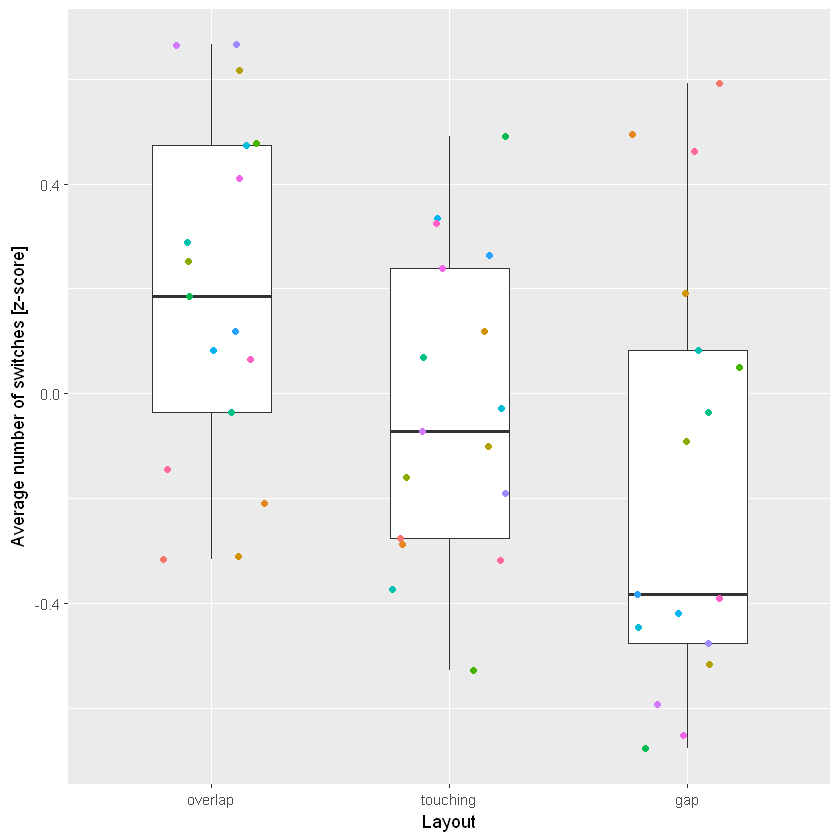

In [225]:
ambiguous.gap <- reports %>%
    filter(Unambiguious == 'neither') %>%
    filter(is.finite(counter.rotation)) %>%
    # counting number of switches per object
    group_by(Observer, Block, Gap) %>%
    summarise(left.switch.count= ifelse(unambiguous.L[1], NA, sum(left.switch, na.rm= TRUE)), # ignoring disambiguated object
              right.switch.count= ifelse(unambiguous.R[1], NA, sum(right.switch, na.rm= TRUE)), # ignoring disambiguated object
              mean.switch.count= mean(c(left.switch.count, right.switch.count)),
              counter.rotation.prop= sum(Duration[counter.rotation])/sum(Duration, na.rm = TRUE),
              disbalance= abs(counter.rotation.prop-0.5),
              balanced= (counter.rotation.prop>0.25) & (counter.rotation.prop<0.75)) %>%
    filter(is.finite(mean.switch.count))

# using gap as the only factor in LMER
gap.as.only.factor <- lmerTest::lmer(mean.switch.count ~ Gap + (1|Observer), data= ambiguous.gap)
summary(gap.as.only.factor)
coefficients.only <- data.frame(summary(gap.as.only.factor)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))


ambiguous.gap.normalized <- ambiguous.gap %>%
    group_by(Observer) %>%
    mutate(Z.switch= c(scale(mean.switch.count)), 
           Z.disbalance= c(scale(disbalance))) %>%

    group_by(Observer, Gap) %>%
    summarise(mean.switch.count= mean(Z.switch), 
              mean.disbalance= mean(disbalance))


swith_per_gap_plot <- ggplot(data= ambiguous.gap.normalized, aes(x= Gap, y= mean.switch.count))+
    geom_boxplot(outlier.shape =  NA, width= 0.5)+
    geom_jitter(aes(color= Observer), width= 0.25)+
#     ylim(0, 0.7)+
    ylab('Average number of switches [z-score]')+
    xlab('Layout')+
    theme(legend.position="none")
print(swith_per_gap_plot)
# ggsave('Figures/Exp1 - effect of gap on switching.pdf', swith_per_gap_plot, width= 6, height= 6.5, units = 'cm',  useDingbats = FALSE)

### Computing perceptual trapping: probability that both objects switch simultaneously
For the perceptual trapping analysis, we restrict ourselves only to the blocks within 25%-75% range. The probability is computed relative to randomly shuffled distribution of same perceptual events and then is Z-scored to make it more comparable between observers

Number of balanced blocks: 46
Number of balanced participants: 11


Joining, by = c("Observer", "Block")



	One Sample t-test

data:  perceptual.trapping$z.trapped
t = -3.2739, df = 45, p-value = 0.002043
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -1.1161065 -0.2659054
sample estimates:
 mean of x 
-0.6910059 


R^2: 0.44

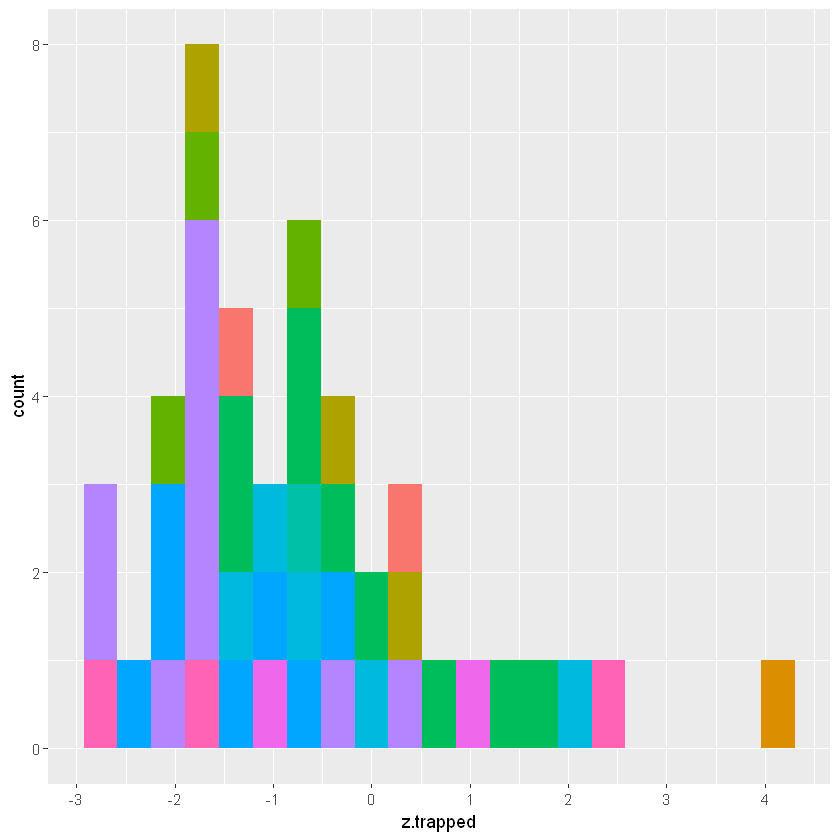

In [16]:
balanced.blocks <- eligible.blocks %>%
    filter(balanced)
cat(sprintf('Number of balanced blocks: %d\n', nrow(balanced.blocks)))
cat(sprintf('Number of balanced participants: %d\n', length(unique(balanced.blocks$Observer))))


persistence.relative.to.chance.level <- function(perceptual.reports){
    reports.N <- length(perceptual.reports)
    actual.persistence <- mean(perceptual.reports[1:(reports.N-1)]==perceptual.reports[2:reports.N])

    shuffle.repetitions <- 1000
    shuffled.persistence <- rep(NA, shuffle.repetitions) 
    for(iteration in 1:shuffle.repetitions){
        shuffled.reports <- sample(perceptual.reports)
        shuffled.persistence[iteration] <- mean(shuffled.reports[1:(reports.N-1)]==shuffled.reports[2:reports.N])
    }    

    # z-scoring the actual persistence based on the randomly sampled sequences
    z.scores <- c(scale(c(actual.persistence, shuffled.persistence)))
    return(z.scores[1])
    
    # computing there the actual persistence is relative to a distribution of randomly shuffled reports
    # we need to use -, as t-test measures distance from the center of distribution to the value and we need it the other way around
#     return(-t.test(logit(shuffled.persistence), mu= logit(actual.persistence))$statistic)
}

perceptual.trapping <- reports %>% 
    semi_join(balanced.blocks) %>%
    
    # adding unique block index
    group_by(Observer, disambiguation.method, Block, Shape, Gap, ambiguity) %>%
    mutate(block.id= str_c(as.character(Observer[1]), as.character(disambiguation.method[1]), as.character(Block[1]), as.character(Shape[1]), as.character(Gap[1]), as.character(ambiguity[1]))) %>%
    ungroup() %>%
    mutate(block.id= as.factor(block.id)) %>%
    
    # computing probability of perceptual trapping
    filter(is.finite(counter.rotation)) %>%
    group_by(Observer,block.id) %>%
    summarise(p.trapped= mean(counter.rotation[1:(n()-1)]==counter.rotation[2:n()]),
              z.trapped= persistence.relative.to.chance.level(counter.rotation)) 

t.trapped <- t.test(perceptual.trapping$z.trapped)
t.trapped
cat(sprintf('R^2: %.2f', rcontrast(t.trapped$statistic, t.trapped$parameter)))

trapping.plot <- ggplot(data= perceptual.trapping, aes(x= z.trapped, fill= Observer)) + 
    geom_histogram(bins= 21)+
    scale_y_continuous(breaks= seq(0, 10, 2))+
    scale_x_continuous(breaks= seq(-5, 5, 1))+
    theme(legend.position="none")
print(trapping.plot)
ggsave('Figures/Exp1 - perceptual trapping.pdf', trapping.plot, width= 8.5, height= 5.5, units = 'cm',  useDingbats = FALSE)

### Computing perceptual stability when an object switch into a new state alone or together with another object

In [17]:
avg.duration.switch.based <- function(switch.flag, eligible.switches, duration, ambiguous){
    
    if (sum(switch.flag & eligible.switches & ambiguous)==1){
        # we are not seriosly considering a single event stats, are we?
        return(NA)
    }
    
    return(mean(duration[switch.flag & eligible.switches]));
    
}

perceptual.stability <- perceptual.trapping <- reports %>% 
    semi_join(eligible.blocks) %>%

    # dropping all non-switch events (onsets and ofsets)
    filter(is.finite(both.switch)) %>%
    
    # normalizing duration for each percept within each block, since we are interested in a relative effect of the switch
    mutate(N.left= c(scale(D.left)), #/mean(D.left, na.rm= TRUE), 
           N.right= c(scale(D.right))) %>% #/mean(D.right, na.rm= TRUE)) %>%

    # computing average duration for indepedently switched percepts versus percepts switched in accord
    group_by(Observer, Block) %>%
    summarise(independent= avg.duration.switch.based(switch.flag= c(left.switch, right.switch), 
                                              eligible.switches= c(left.switch!=right.switch, left.switch!=right.switch), 
                                              duration= c(N.left, N.right), 
                                              ambiguous= c(!unambiguous.L, !unambiguous.R)),
           simultaneous= avg.duration.switch.based(switch.flag= c(left.switch, right.switch), 
                                              eligible.switches= c(left.switch==right.switch, left.switch==right.switch)==TRUE, 
                                              duration= c(N.left, N.right),
                                              ambiguous= c(!unambiguous.L, !unambiguous.R)),
           together.vs.indep= simultaneous-independent, 
           counter.rotation.prop= sum(Duration[counter.rotation])/sum(Duration, na.rm = TRUE), 
           balance= abs(counter.rotation.prop-0.5)) %>%

    # dropping NA rows, because that means tha either there were no independent or simultaneous switches
    filter(is.finite(together.vs.indep))

Joining, by = c("Observer", "Block")


Converting table from wide to narrow, so that switch type is a factor

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: avg.duration ~ switch + (1 | Observer)
   Data: stability.after.switch

REML criterion at convergence: 175.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3854 -0.4499 -0.0041  0.3850  4.3792 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.0000   0.0000  
 Residual             0.1433   0.3785  
Number of obs: 188, groups:  Observer, 14

Fixed effects:
                    Estimate Std. Error        df t value Pr(>|t|)
(Intercept)          0.01323    0.03904 186.00000   0.339    0.735
switchsimultaneous  -0.01187    0.05522 186.00000  -0.215    0.830

Correlation of Fixed Effects:
            (Intr)
swtchsmltns -0.707

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.01322970,0.03904374,186,0.3388431,0.7351101,0.02483752
-0.01186976,0.05521619,186,-0.2149689,0.8300271,0.01576032


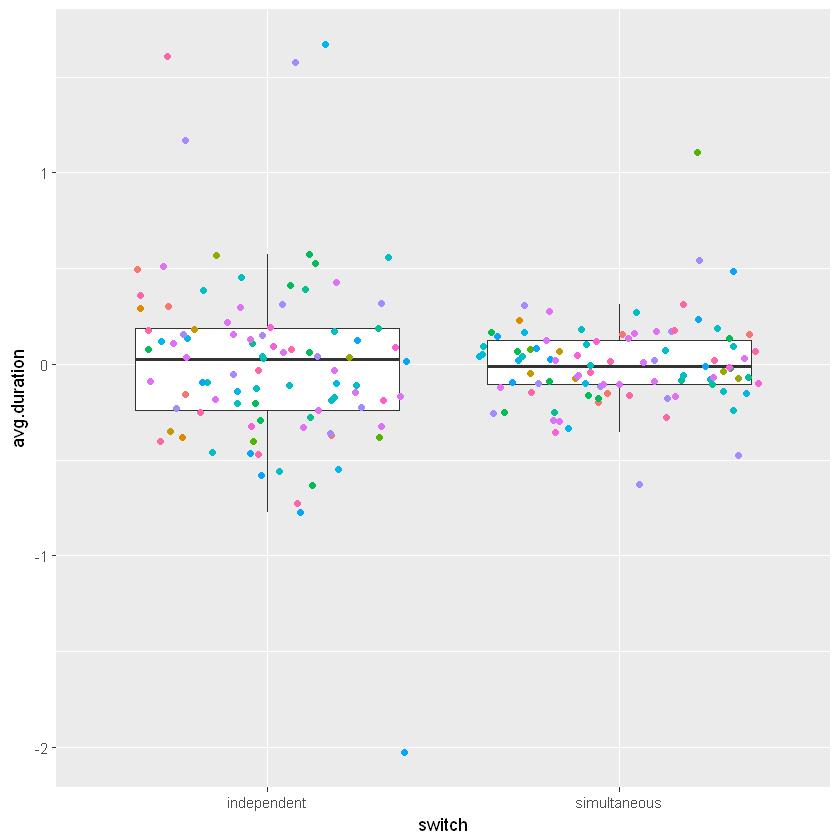

In [18]:
stability.after.switch <- perceptual.stability %>%
    gather(key = 'switch', value = 'avg.duration', independent, simultaneous) %>%
    mutate(switch = as.factor(switch)) %>%
    
    # just so that it is easier to see the data, makes no difference for the analysis
    arrange(Observer, Block)

switch.as.factor <- lmerTest::lmer(avg.duration ~ switch + (1|Observer), data= stability.after.switch)
summary(switch.as.factor)
coefficients.only <- data.frame(summary(switch.as.factor)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

stability.after.switch.plot <- ggplot(data= stability.after.switch, aes(x= switch, y= avg.duration, color= Observer, group= switch))+
    geom_boxplot(outlier.shape = NA)+
    geom_jitter(width= 0.4)+
    theme(legend.position="none")
print(stability.after.switch.plot)

ggsave('Figures/Exp1 - post switch duration.pdf', stability.after.switch.plot, width= 5, height= 4.5, units = 'cm',  useDingbats = FALSE)

In [19]:
balance.effect <- lmerTest::lmer(together.vs.indep ~ balance + (1|Observer), data= perceptual.stability)
summary(balance.effect)
coefficients.only <- data.frame(summary(balance.effect)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: together.vs.indep ~ balance + (1 | Observer)
   Data: perceptual.stability

REML criterion at convergence: 184.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.09656 -0.59768 -0.07194  0.69674  3.15210 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.02314  0.1521  
 Residual             0.39196  0.6261  
Number of obs: 94, groups:  Observer, 14

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)
(Intercept) -0.007527   0.141907 36.700000  -0.053    0.958
balance      0.017579   0.460346 91.880000   0.038    0.970

Correlation of Fixed Effects:
        (Intr)
balance -0.827

Estimate,Std.Error,df,t.value,p.value,R.sqr
-0.007526932,0.1419074,36.69839,-0.05304114,0.9579868,0.008755333
0.017579027,0.4603463,91.88234,0.03818652,0.9696218,0.003983737
